In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import os
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/semantic_segmentation")

In [4]:
!pip install -r requirements.txt

In [5]:
# import necessary functions
from data_handler.data import get_dataset, get_dataloader
from data_handler.data_visualization_nd_stats import (
    show_samples, 
    show_samples_superposed,
    compute_class_distribution,
    compute_class_weights,
    plot_class_distribution,
    visualize_sample_predictions,
    )
from model_builder.model import *
from utils.utils import visualize_training_plots

ImportError: cannot import name 'SegformerImageProcessor' from 'transformers' (C:\Users\Gokulnath Anand\anaconda3\Lib\site-packages\transformers\__init__.py)

# Download the CamSeq1 dataset

In [ ]:
# downloading the dataset
!python ./utils/download_dataset.py --savedir="./dataset/camvid/"

# Data Exploration

In [ ]:
train_dataset, val_dataset = get_dataset(
    data_path='./dataset/camvid/',
    val_split=0.2,
    random_state=42,
    feature_extractor_name='nvidia/segformer-b2-finetuned-cityscapes-1024-1024'
    )

In [ ]:
show_samples(train_dataset, 3, random=True)

In [ ]:
show_samples_superposed(train_dataset,3,random=True)

In [ ]:
summary = compute_class_distribution(train_dataset)
plot_class_distribution(train_dataset.id2label.values(),summary)

# Creating and Fine Tuning the model

In [ ]:
train_dl, val_dl = get_dataloader([train_dataset,val_dataset])
class_weights = compute_class_weights(sum(summary),summary)

In [ ]:
id2label = train_dataset.id2label
trainer, model = train_model(train_dl,
            val_dl,
            class_weights,
            id2label,
            hf_model_name="nvidia/segformer-b2-finetuned-cityscapes-1024-1024",
            ckpt_path='./checkpoints/',
            accelerator_mode='gpu',
            devices=1,
            max_epochs=300,
            log_every_n_steps=8
            )

## Resume Training the model

In [ ]:
#train_dl, val_dl = get_dataloader([train_dataset,val_dataset])
#class_weights = compute_class_weights(sum(summary),summary)
#id2label = train_dataset.id2label
trainer, model = train_model(train_dl,
            val_dl,
            class_weights,
            id2label,
            hf_model_name="nvidia/segformer-b2-finetuned-cityscapes-1024-1024",
            ckpt_path='./checkpoints/',
            accelerator_mode='gpu',
            devices=1,
            max_epochs=300,
            log_every_n_steps=8,
            last_ckpt_path='./checkpoints/lightning_logs/version_3/checkpoints/epoch=99-step=800.ckpt',
            resume=True
            )

## Evaluating the model

In [ ]:
res = trainer.validate(ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at checkpoints/lightning_logs/version_8/checkpoints/epoch=194-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at checkpoints/lightning_logs/version_8/checkpoints/epoch=194-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.29798245429992676
    val_mean_accuracy       0.9053388663729783
      val_mean_iou           0.682776180739859
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Ploting loss and metrics evolution during training and validation

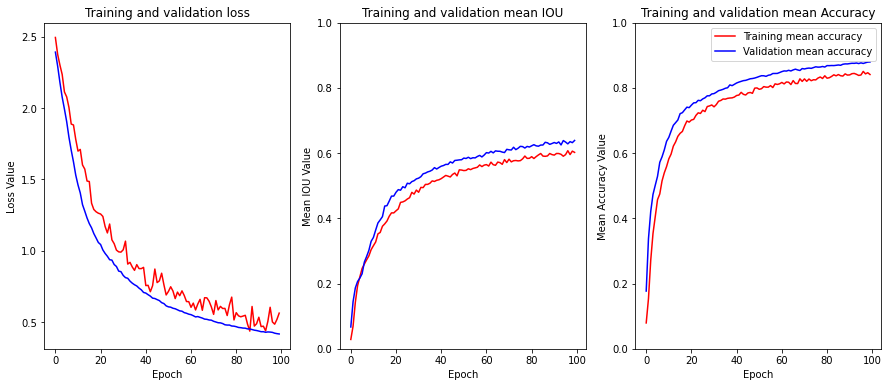

In [ ]:
visualize_training_plots("./checkpoints_/lightning_logs/version_0/metrics.csv")

## Visualizing Prediction Samples

In [15]:
from model_builder.model import SegFormerFineTuned
from data_handler.data_visualization_nd_stats import (
    visualize_sample_predictions,
    visualize_predictions_superposed,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([12, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


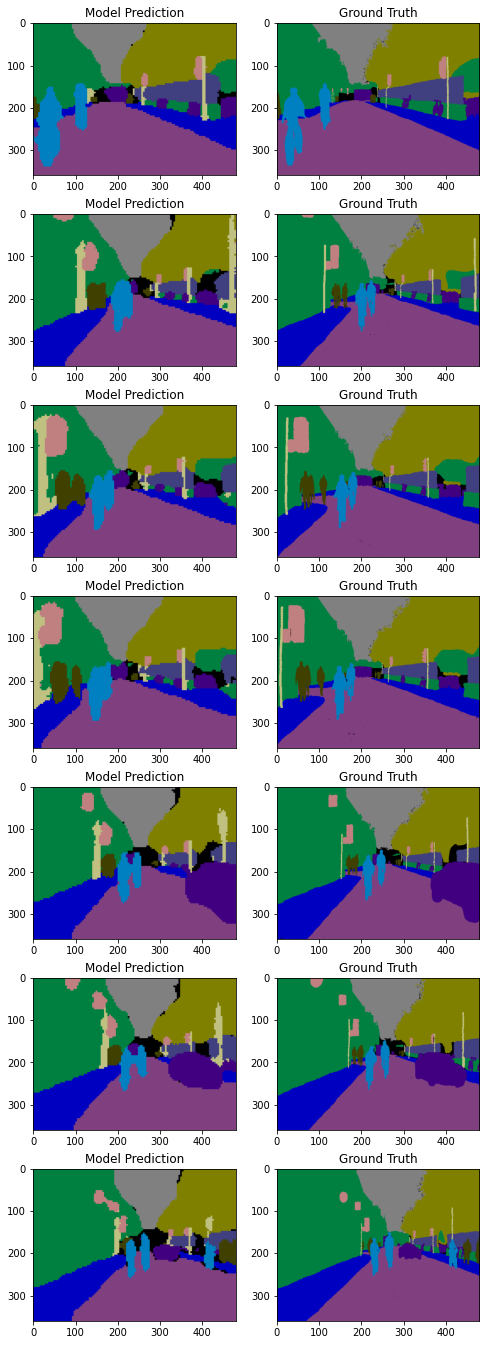

In [16]:
model = SegFormerFineTuned.load_from_checkpoint('./checkpoints/lightning_logs/version_8/checkpoints/epoch=194-step=1560.ckpt')
colormap = val_dataset.class_colors        
visualize_sample_predictions(val_dl,model,colormap)

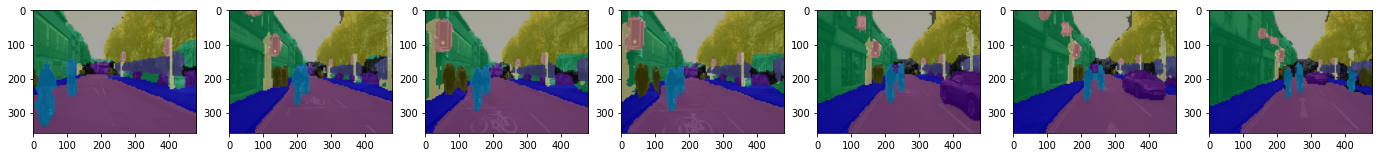

In [18]:
visualize_predictions_superposed(val_dl,model,colormap)